# Visualization of CO2 emissions per country, comparing it to their population

In this notebook, we used co2_emission_complicated.csv and world_population.csv files to compare how the population affects the emissions. 

In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

### Preparing data

There were many different datasets for the population. The one we chose includes Rank (lower rank -> bigger population), population in different years (1970-2020, per 10 years), area (km^2), density (per km^2), world population percentage. With the additional data like density and percentage, we can do more interesting visualizations.

In [2]:
data_root = './data/'
data_root_world = './data/cultural/'

In [3]:
df_co2 = pd.read_csv(f'{data_root}co2_emmisions_complicated.csv')
df_pop = pd.read_csv(f'{data_root}world_population.csv')

world = gpd.read_file(f'{data_root_world}ne_110m_admin_0_countries.shp')

The datasets include information on the whole world, which is a lot of data. We decided to narrow it down to only European countries as it's more manageable and easier for the viewer.

In [4]:
# Filtering the data only for European countries
df_co2_europe = df_co2[df_co2['Region'].str.contains('Europe', case=False, na=False)]

# Add Russia
df_russia = df_co2[df_co2['Name'].str.contains('Russian Federation', case=False, na=False)].copy()
df_russia['Name'] = df_russia['Name'].replace('Russian Federation', 'Russia')

# Add Ukraine
df_ukraine = df_co2[df_co2['Name'].str.contains('Ukraine', case=False, na=False)].copy()

# Add Belarus
df_belarus = df_co2[df_co2['Name'].str.contains('Belarus', case=False, na=False)].copy()

# Add Moldova
df_moldova = df_co2[df_co2['Name'].str.contains('Moldova', case=False, na=False)].copy()
df_moldova['Name'] = df_moldova['Name'].replace('Moldova, Republic of', 'Moldova')

# Combine all
df_co2_europe = pd.concat([df_co2_europe, df_russia, df_ukraine, df_belarus, df_moldova]).drop_duplicates()

df_pop_europe = df_pop[df_pop['Continent'] == 'Europe']

In [5]:
row = df_co2_europe[df_co2_europe['Name'] == 'Serbia and Montenegro'].copy()

serbia_row = row.copy()
montenegro_row = row.copy()

serbia_row['Country_code'] = 'SRB'
serbia_row['Name'] = 'Serbia'

montenegro_row['Country_code'] = 'MNE'
montenegro_row['Name'] = 'Montenegro'

year_columns = [col for col in df_co2_europe.columns if col.isdigit()]

# Split the CO2 data by 85% and 15% because Serbia is much bigger than Montenegro by area and by population
serbia_row[year_columns] = row[year_columns] * 0.96
montenegro_row[year_columns] = row[year_columns] * 0.04

# Drop the original Serbia and Montenegro row
df_co2_europe = df_co2_europe[df_co2_europe['Name'] != 'Serbia and Montenegro']

# Append the two new rows
df_co2_europe = pd.concat([df_co2_europe, serbia_row, montenegro_row], ignore_index=True)

For the european map visualization, we downloaded from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/

### Problems

One problem was merging the data sets as they each provide their amount of data for each country. As we can see below, there is data missing for some countries in Europe, which leads to missing data in visualization such as the Europe map visualization.

So we'll work with the amount of countries that is in the shorter dataset (which is CO2 dataset with 40 European countries).

In [6]:
# unique country names from CO2 and population datasets
co2_countries = set(df_co2_europe['Name'].dropna().unique())
pop_countries = set(df_pop_europe['Country/Territory'].dropna().unique())

print(f"Countries in CO2 dataset ({len(co2_countries)}):\n{sorted(co2_countries)}\n")
print(f"Countries in Population dataset ({len(pop_countries)}):\n{sorted(pop_countries)}\n")

# countries in both datasets
both = co2_countries & pop_countries
print(f"Countries in BOTH datasets ({len(both)}):\n{sorted(both)}\n")

# countries only in CO2 dataset
only_co2 = co2_countries - pop_countries
print(f"Countries ONLY in CO2 dataset ({len(only_co2)}):\n{sorted(only_co2)}\n")

# countries only in population dataset
only_pop = pop_countries - co2_countries
print(f"Countries ONLY in Population dataset ({len(only_pop)}):\n{sorted(only_pop)}")

Countries in CO2 dataset (40):
['Albania', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom']

Countries in Population dataset (50):
['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czech Republic', 'Denmark', 'Estonia', 'Faroe Islands', 'Finland', 'France', 'Germany', 'Gibraltar', 'Greece', 'Guernsey', 'Hungary', 'Iceland', 'Ireland', 'Isle of Man', 'Italy', 'Jersey', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Moldova', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway',

# Visualization

As the first visualization, we did a simple time chart, which shows the population (blue) and CO2 emissions (tons - red) throughout the years: '1970', '1980', '1990', '2000', '2010', '2015', '2020', '2022'.

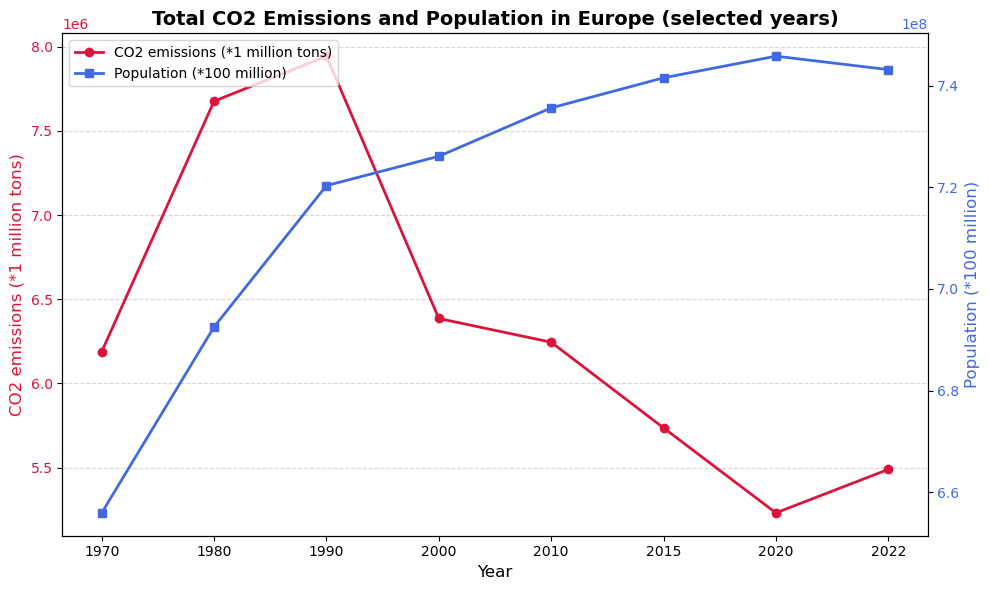

In [7]:
years = ['1970', '1980', '1990', '2000', '2010', '2015', '2020', '2022']

df_co2_filtered = df_co2_europe[['Name'] + years]

pop_years = [f"{year} Population" for year in [1970, 1980, 1990, 2000, 2010, 2015, 2020, 2022]]
df_pop_filtered = df_pop_europe[['Country/Territory'] + pop_years]

# total CO2 per year
co2_total = df_co2_filtered[years].sum()

# total population per year
pop_total = df_pop_filtered[pop_years].sum()
pop_total.index = years # index -> years

fig, ax1 = plt.subplots(figsize=(10,6))

# CO2 emissions
ax1.plot(years, co2_total, color='crimson', marker='o', linewidth=2, label='CO2 emissions (*1 million tons)')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('CO2 emissions (*1 million tons)', color='crimson', fontsize=12)
ax1.tick_params(axis='y', labelcolor='crimson')
ax1.grid(True, which='both', axis='y', linestyle='--', alpha=0.5)

# second Y-axis for population
ax2 = ax1.twinx()
ax2.plot(years, pop_total, color='royalblue', marker='s', linewidth=2, label='Population (*100 million)')
ax2.set_ylabel('Population (*100 million)', color='royalblue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='royalblue')

plt.title('Total CO2 Emissions and Population in Europe (selected years)', fontsize=14, weight='bold')

# legend
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

As we can see, the CO2 emissions started falling from 1980 onwards, till 2020 when the corona virus came. The population line is pretty much flipped (compared to CO2 emissions) as it was rising till the corona virus which caused a slight decline in numbers.

The next section is top 10 European countries by CO2 emissions and top 10 European countries by population for the latest year 2022.

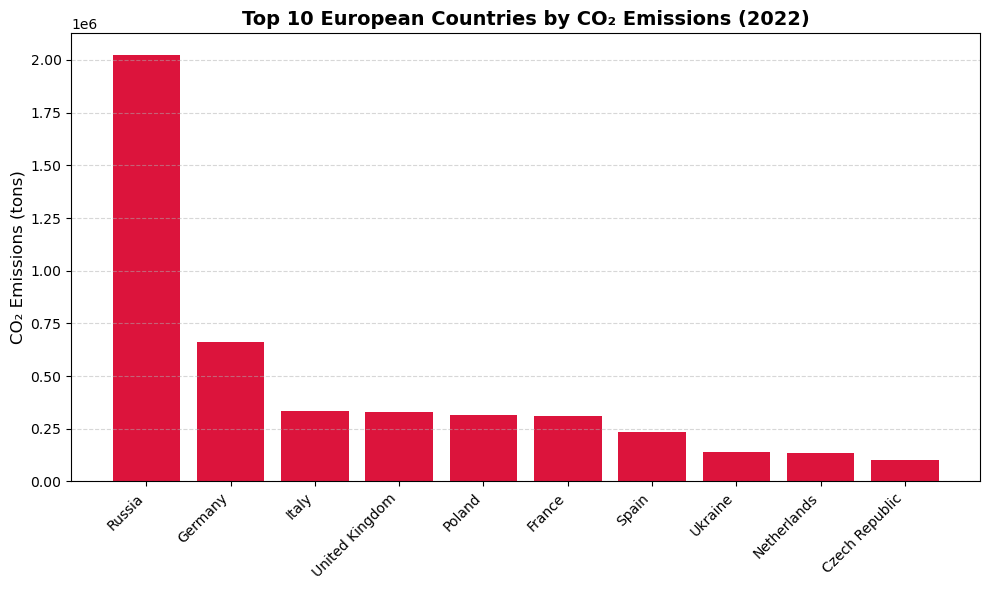

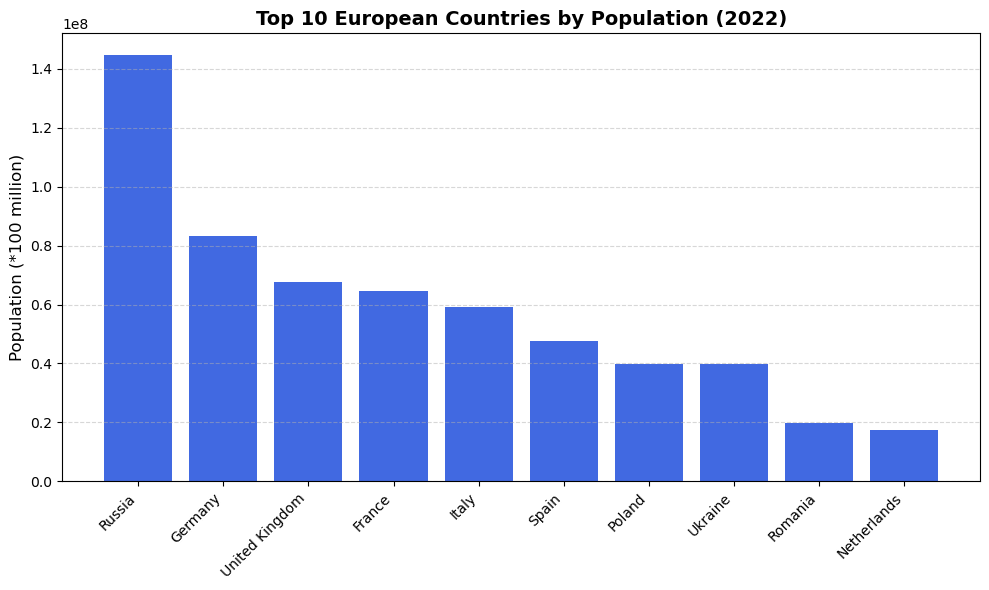

In [8]:
year = '2022'
top10_co2 = (
    df_co2_europe[['Name', year]]
    .sort_values(by=year, ascending=False)
    .head(10)
)

# Bar graph
plt.figure(figsize=(10,6))
plt.bar(top10_co2['Name'], top10_co2[year], color='crimson')
plt.ylabel('CO₂ Emissions (tons)', fontsize=12)
plt.title(f'Top 10 European Countries by CO₂ Emissions ({year})', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


pop_year = '2022 Population'
top10_pop = (df_pop_europe[['Country/Territory', pop_year]].sort_values(by=pop_year, ascending=False).head(10))

# Bar graf
plt.figure(figsize=(10,6))
plt.bar(top10_pop['Country/Territory'], top10_pop[pop_year], color='royalblue')
plt.ylabel('Population (*100 million)', fontsize=12)
plt.title('Top 10 European Countries by Population (2022)', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

As we've analyzed and shown the top 10 countries by CO2 emissions in the notebook "CO2_emissions_by_country.ipynb" we can see that some of the countries wtih bigger population count aren't even in the top 10 European countries by CO2 emissions (like Romania or Ukraine).

Next we normalized the data and made a visualization for CO2 emissions per capita.

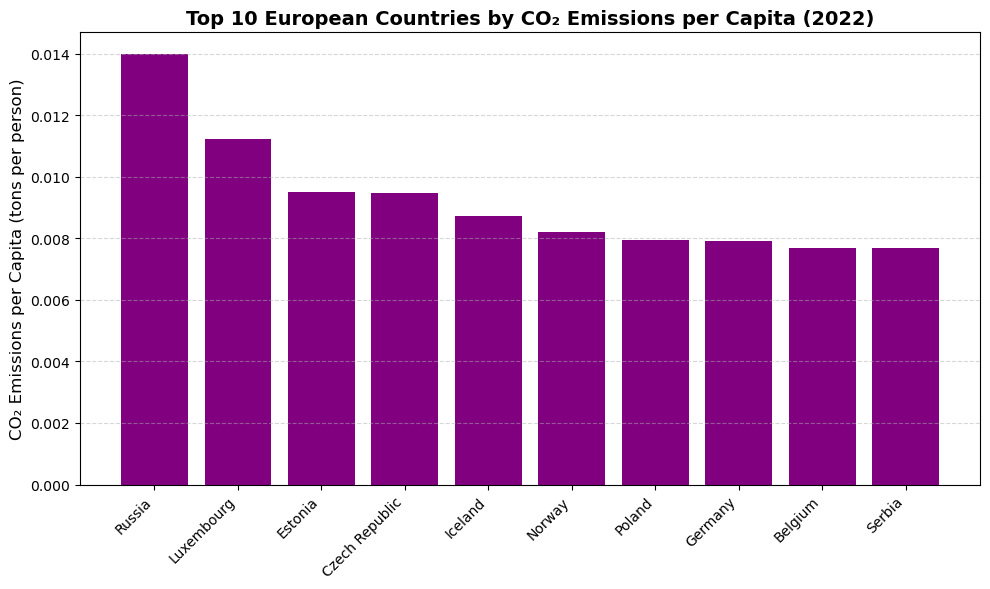

In [9]:
co2_2022 = df_co2_europe[['Name', '2022']]
pop_2022 = df_pop_europe[['Country/Territory', '2022 Population']]

#merge countries by name
df_merged = pd.merge(co2_2022, pop_2022, left_on='Name', right_on='Country/Territory', how='inner')

#emissions per capita
df_merged['CO2_per_capita'] = df_merged['2022'] / df_merged['2022 Population']

#top 10
top10_per_capita = df_merged.sort_values(by='CO2_per_capita', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top10_per_capita['Name'], top10_per_capita['CO2_per_capita'], color='purple')
plt.ylabel('CO₂ Emissions per Capita (tons per person)', fontsize=12)
plt.title('Top 10 European Countries by CO₂ Emissions per Capita (2022)', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The interesting part about this graph is that it shows countries that weren't even in the top 10 CO2-emitting European countries (Luxembourg, Bulgaria, Iceland, Czech Republic). As expected, smaller countries like Luxembourg might not initially seem likely to top the list of CO₂ emissions per capita. However, the data shows that Luxembourg ranks second in Europe by this metric. This is likely due to its small population combined with relatively high overall emissions. One possible explanation lies in its historical and economic ties with Germany — Europe’s largest CO₂ emitter — which may influence its energy consumption and industrial activity. While Russia still keeps the top 1 position even for CO2 emissions per capita.

What about back in 1970? Let's see.

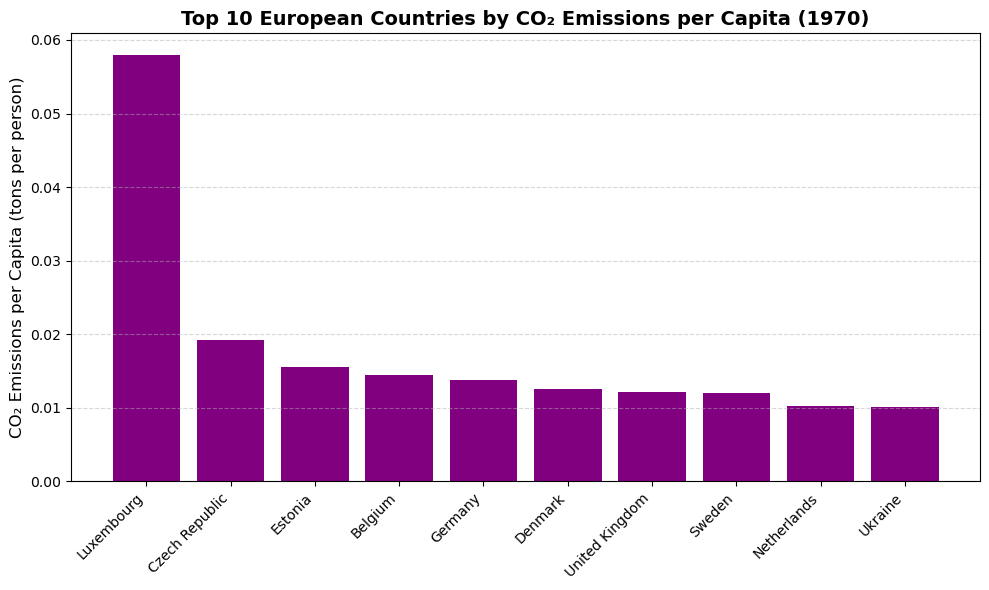

In [10]:
co2_1970 = df_co2_europe[['Name', '1970']]
pop_1970 = df_pop_europe[['Country/Territory', '1970 Population']]

#merge countries by name
df_merged = pd.merge(co2_1970, pop_1970, left_on='Name', right_on='Country/Territory', how='inner')

#emissions per capita
df_merged['CO2_per_capita'] = df_merged['1970'] / df_merged['1970 Population']

#top 10
top10_per_capita = df_merged.sort_values(by='CO2_per_capita', ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top10_per_capita['Name'], top10_per_capita['CO2_per_capita'], color='purple')
plt.ylabel('CO₂ Emissions per Capita (tons per person)', fontsize=12)
plt.title('Top 10 European Countries by CO₂ Emissions per Capita (1970)', fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate country labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


If we compare the 1970/2022 European Countries by CO2 emission per capita graph and Total CO2 Emissions in Europe by Years graph (graph on top of the page), we can see how the 2022 shows much less CO2 emission per person than in 1970 as then the CO2 emissions were higher and the population was lower. With population increasing and CO2 emissions decreasing, the CO2 emission per person is much lower.

How about comparing yearly growth for the population and for CO2 emissions but in percents (%)? We can use a simple formula:
growth_year = ((value_year - value_prev)/value_prev) * 100 
and then show the growth in %.

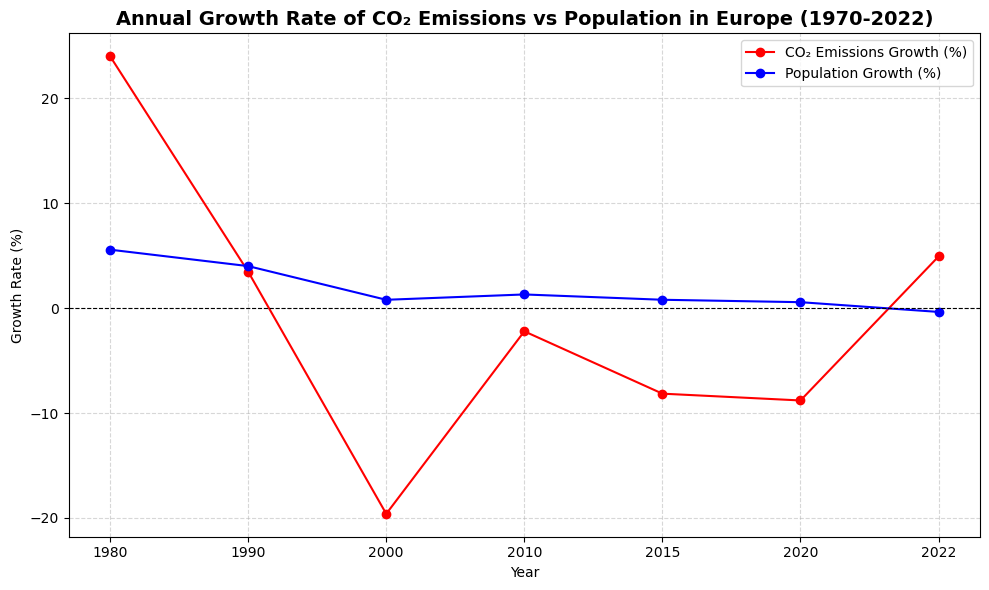

In [11]:
years = ['1970', '1980', '1990', '2000', '2010', '2015', '2020', '2022']
pop_cols = [f'{year} Population' for year in years]

# skupne vrednosti za EU
co2_total = df_co2_europe[years].sum()
pop_total = df_pop_europe[pop_cols].sum()
pop_total.index = years  # poravnamo indekse

co2_growth = co2_total.pct_change() * 100
pop_growth = pop_total.pct_change() * 100

plt.figure(figsize=(10,6))
plt.plot(co2_growth.index, co2_growth.values, label='CO₂ Emissions Growth (%)', marker='o', color='red')
plt.plot(pop_growth.index, pop_growth.values, label='Population Growth (%)', marker='o', color='blue')

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Annual Growth Rate of CO₂ Emissions vs Population in Europe (1970-2022)', fontsize=14, weight='bold')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


The graph pretty much shows similar results as the top graph, only difference is that this one shows growth (or otherwise) in percents (%). What can we read off this graph?
If the CO2 emissions are falling and population is growing, that means we (as humanity) are doing something good for the nature (lowering emissions by switching to better (renewable) energy sources and such). We can also see some spikes, like in 2020 how the CO2 emissions grow a lot as a result that the COVID-19 lockdowns were over.

For a much better visualization of the data, we can also use the map of Europe for the year 2020. 


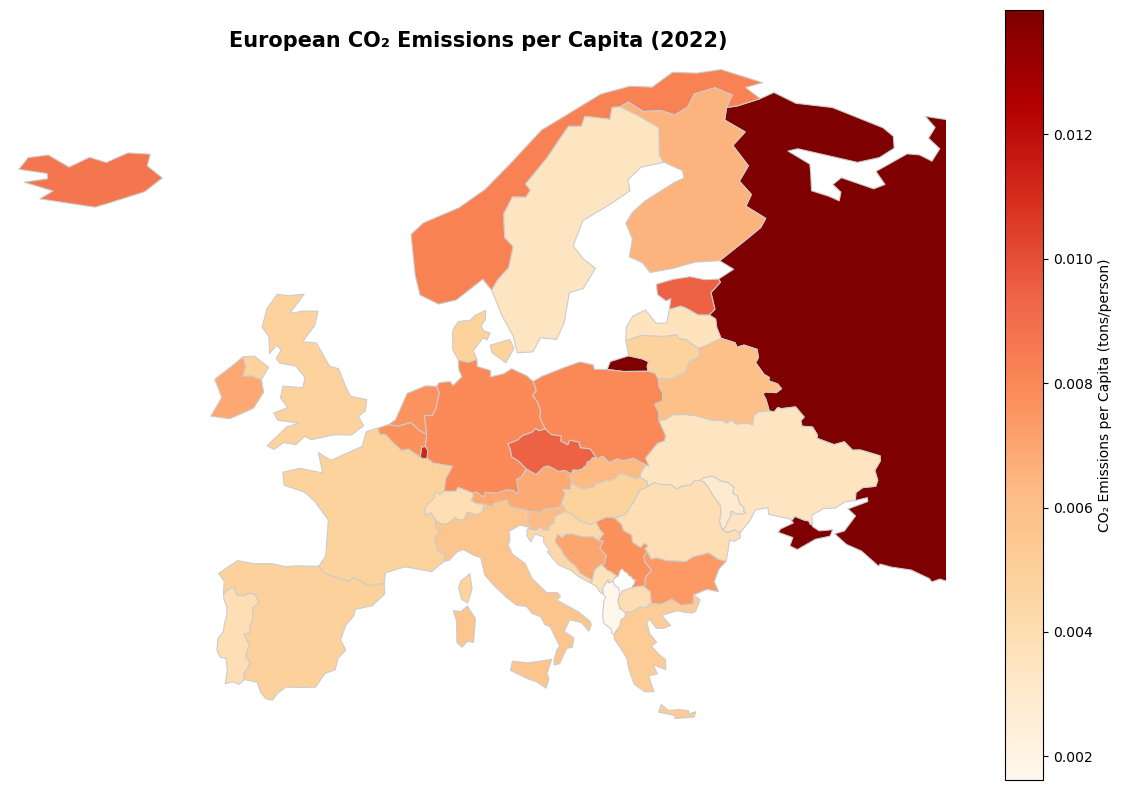

In [12]:
df_co2_europe['Name'] = df_co2_europe['Name'].replace('Czech Republic', 'Czechia') # fixing the name of Czech Republic because in world datafram iti s Czechia
co2_2022 = df_co2_europe[['Name', '2022']].copy()
pop_2022 = df_pop_europe[['Country/Territory', '2022 Population']].copy()
pop_2022['Country/Territory'] = pop_2022['Country/Territory'].replace('Czech Republic', 'Czechia') # same here


df_merged = pd.merge(co2_2022, pop_2022, left_on='Name', right_on='Country/Territory', how='inner')
df_merged['CO2_per_capita'] = df_merged['2022'] / df_merged['2022 Population']

df_merged['Name'] = df_merged['Name'].replace('Czhech Republic', 'Czechia')
df_merged['Name'] = df_merged['Name'].replace({'Bosnia and Herzegovina': 'Bosnia and Herz.'})



map_df = world.merge(df_merged, left_on='NAME', right_on='Name')

# filter for EU
map_df = map_df[map_df['CONTINENT'] == 'Europe']

# set bounds for Europe,so it doesn't zoom out (there is probably a French owned territory, that makes the map zoom out)
minx, miny, maxx, maxy = -25, 34, 45, 72 

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
map_df.plot(
    column='CO2_per_capita',
    cmap='OrRd',
    linewidth=0.8,
    edgecolor='0.8',
    legend=True,
    ax=ax,
    legend_kwds={'label': "CO₂ Emissions per Capita (tons/person)"}
)

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_title('European CO₂ Emissions per Capita (2022)', fontsize=15, weight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

As said in the Problems part, there's missing data for certain countries.

From the map, we can see, Russia and Luxembourg are still in the lead when it comes to CO2 emissions per capita.

The next section is about comparing the CO2 emissions per capita compared to the density for the year 2020.

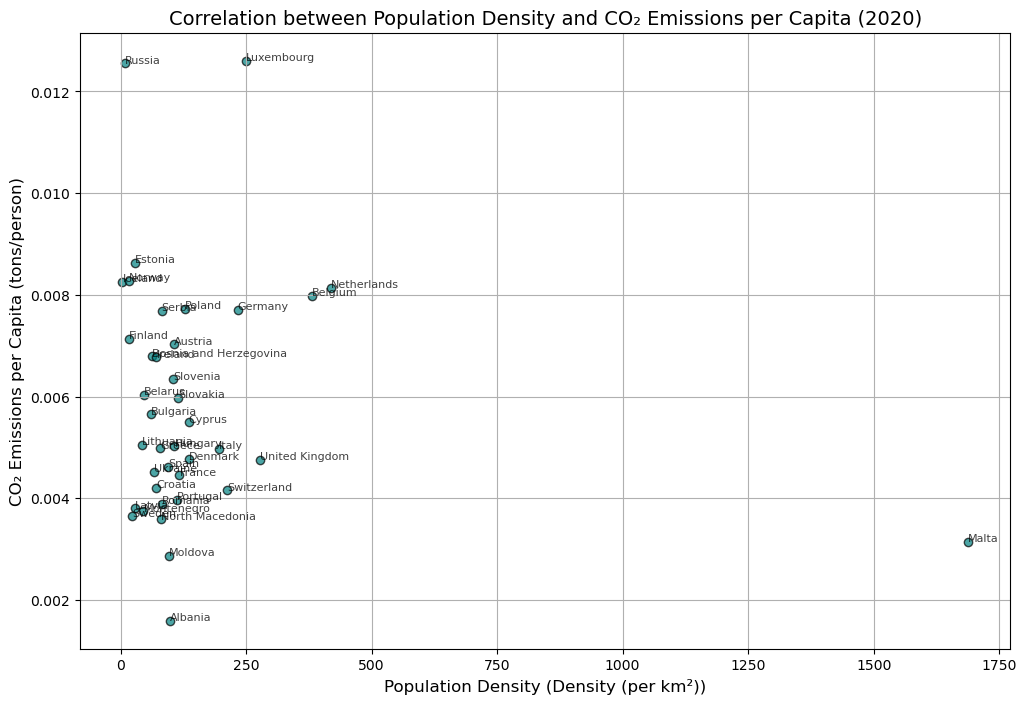

In [13]:
density_col = df_pop_europe.columns[14]

pop_2020 = df_pop_europe[['Country/Territory', density_col, '2020 Population']].copy()
co2_2020 = df_co2_europe[['Name', '2020']].copy()

df_merge = pd.merge( pop_2020, co2_2020, left_on='Country/Territory', right_on='Name', how='inner')

df_merge['CO2_per_capita'] = df_merge['2020'] / df_merge['2020 Population']

plt.figure(figsize=(12, 8))
plt.scatter(
    df_merge[density_col],
    df_merge['CO2_per_capita'],
    alpha=0.7,
    color='teal',
    edgecolors='k'
)

plt.xlabel(f'Population Density ({density_col})', fontsize=12)
plt.ylabel('CO₂ Emissions per Capita (tons/person)', fontsize=12)
plt.title('Correlation between Population Density and CO₂ Emissions per Capita (2020)', fontsize=14)
plt.grid(True)

# country points
for i, row in df_merge.iterrows():
    plt.text(row[density_col], row['CO2_per_capita'], row['Country/Territory'], fontsize=8, alpha=0.75)

plt.show()

The scatter plot illustrates the relationship between population density and CO₂ emissions per capita across European countries in 2020. While one might expect denser populations to correlate with higher per-person emissions, the graph reveals no strong linear trend. Notably, Luxembourg stands out as an outlier, with the highest CO₂ emissions per capita despite its relatively low population density — likely due to its high consumption and cross-border economic activity. Another outlier that is clearly seen on the graph is Russia, which is self explanitory, the biggest country in the world, with the biggest population in Europe, with highly developed industry. Conversely, Malta, the most densely populated country, has among the lowest emissions per capita. This suggests that factors beyond just population density, such as energy sources, economic structure, and transportation habits, play significant roles in shaping national carbon footprints.